In [1]:
from settings import s, e
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle
from PIL import Image
from collections import deque

from IPython.display import HTML, clear_output, display, update_display
import matplotlib.pyplot as plt


from simple import Game, get_valid_actions

from agent_code.simple_agent.wrapper import SimpleAgent

from agent_code.tensor_agent.agent import TensorAgent
from agent_code.tensor_agent.hyperparameters import hp
from agent_code.tensor_agent.X import RelativeX3 as game_state_X
from agent_code.tensor_agent.X import AbsoluteX3, X3_to_imgs
from agent_code.tensor_agent.model import FullModel, Counter

choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
action_y_map = {choices[i]: i for i in range(len(choices))}
D = len(choices)

clear_output()

In [2]:
hp.buffer_size = 100000
hp.target_network_period = 32000
hp.epsilon = 0.
hp.learning_rate=0.001
hp.discount_factor=0.99
hp.peaceful = False
hp.multi_step_n = 3

aux_rewards = {
    e.WAITED: -0.2,
    e.CRATE_DESTROYED: 0.2,
    e.COIN_COLLECTED: 0,
    e.KILLED_OPPONENT: 0,
    e.KILLED_SELF: 0,
    e.GOT_KILLED: -5
}

last_moves_length = 20
last_moves_similarity_penalty = 1 / last_moves_length

hurry_up = 1 * (1 - hp.discount_factor)

In [3]:
class HallOfFame:
    def __init__(self):
        self.weights = []
    
    def add(self, weights):
        self.weights.append(weights)
        if len(self.weights) > 50:
            self.weights = self.weights[::2]

HoF = HallOfFame()

In [4]:


K.clear_session()
#model = FullModel(game_state_X.shape, D)

def make_agent():
    return TensorAgent(game_state_X.shape, D, weights=None, model=FullModel(game_state_X.shape, D))

total_step = 0

tensor_agent = make_agent()

original = 'tensor_agent'
copies = [f'tensor_agent-copy{i}' for i in range(3)]
additional = [f'tensor_agent{i}' for i in range(3)]
simples = [f'simple_agent{i}' for i in range(3)]

agents = {
    original: tensor_agent
}

for n in copies:
    agents[n] = tensor_agent.clone()

for n in additional:
    agents[n] = make_agent()

for n in simples:
    agents[n] = SimpleAgent(game_state_X.shape, D, model=tensor_agent.model, er_buffer=tensor_agent.buffer)

train = {a: False for a in agents}

clear_output()

In [5]:
tensor_agent.model.load_weights('models/self-play7/tensor_agent-model2300001.h5')

loading weights
weights loaded


In [5]:
agents[additional[0]].model.load_weights('self-play2-600k.h5')
HoF.add(agents[additional[0]].model.get_weights())

loading weights
weights loaded


In [6]:
total_step=2300001

In [7]:
from agent_code.tensor_agent.layers import NoisyDense

for layer in tensor_agent.model.online.layers + tensor_agent.model.target.layers:
    if type(layer) == NoisyDense:
        layer.w_sigma.initializer.run(session=K.get_session())
        layer.b_sigma.initializer.run(session=K.get_session())

In [6]:
class AgentInfo(object):
    def __init__(self, agents, moving_rewards):
        self.agents = agents
        self.moving_rewards = moving_rewards

    def _repr_pretty_(self, pp, cycle):
        text = ''
        for n, a in self.agents.items():
            text +=  '=====================\n'
            text += f'{n} ({a.model.family}) \n'
            text += f'trained: {a.model.steps} \n'
            text += f'moving reward: {moving_rewards[n]:.2f} \n'
        pp.text(text)
        
    def __repr__(self):
        return str(self.agents.keys().join(','))

In [14]:
tensor_agent.model.online.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 33, 33, 6)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 33, 33, 32)   224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 17, 17, 64)   32832       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 9, 9, 64)     36928       conv2d_4[0][0]                   
__________________________________________________________________________________________________
cropping2d

In [ ]:
d = display(f'Starting...', display_id='progress')


n_steps = 3000000
game = None
current_agents = {}

train = {n: False for n in agents.keys()}
for n in [original] + copies + simples:
    train[n] = True
#train['tensor_agent'] = True

moving_rewards = {n: 0 for n in agents.keys()}
episode_count = 0

info = AgentInfo(agents, moving_rewards)
agent_display = display(info, display_id='agent_info')



for step in range(total_step, n_steps):
    if game is None:
        episode_count += 1
        
        #=== Choose Agents ===
        agent_choice = np.random.choice([1, 2, 3, 4], p=[0.5, 0., 0., 0.5])
        if agent_choice == 1:
            agent_choice = 'solo'
            current_agents = {n: agents[n] for n in [original]}
        else:
            agent_choices = np.random.choice(['hof', 'clones', 'simples'], agent_choice-1, p=[0.3, 0.4, 0.3])
            current_agents = {original: agents[original]}
            
            for key, cnt in zip(*np.unique(agent_choices, return_counts=True)):
                for i in range(cnt):
                    if key == 'hof':
                        if len(HoF.weights) > 2:
                            n = additional[i]
                            agents[n].model.set_weights(HoF.weights[np.random.choice(len(HoF.weights))])
                        else:
                            n = copies[i]
                    elif key == 'clones':
                        n = copies[i]
                    elif key == 'simples':
                        n = simples[i]
            
                    current_agents[n] = agents[n]
        
        last_moves = {n: deque(maxlen=last_moves_length) for n in current_agents.keys()}
        
        
        #=== Choose Game ===
        choice = np.random.choice(['coins', 'deathmatch', 'full'], p=[0.5,0.,0.5])
        if choice == 'coins':
            game = Game(*Game.create_arena(current_agents.keys(), crate_density=0.), \
                        max_duration=np.random.randint(100, 201))
        elif choice == 'deathmatch' and agent_choice != 'solo':
            game = Game(*Game.create_arena(current_agents.keys(), crate_density=0., coins_per_area=0),\
                        max_duration=np.random.randint(100, 401))
        else: # 'full'
            game = Game(*Game.create_arena(current_agents.keys(),\
                                           crate_density=np.random.uniform(low=0.5, high=1.0)), \
                       max_duration=np.random.randint(200, 401))
        dead_rewards = {}

    total_step += 1
    actions = {}
    Xs = {}
    for agent in game.agents:
        x, y, name, b, _ = agent
        
        game_state = game.get_game_state(agent)
        Xs[name] = game_state_X.get(game_state)
        valid_actions = get_valid_actions(x, y, b, game, prevent_death=False)
        actions[name] = current_agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions, game_state=game_state)
    
    actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
    rewards, events = game.step(actions_as_string)
    
    ex_rewards = {}
    for name in actions.keys():
        moving_rewards[name] = 0.99 * moving_rewards[name] + rewards[name]
        ex_rewards[name] = rewards[name] + np.sum([events[name][event] * aux_rewards[event] for event in aux_rewards.keys()])
    
    #=== Delayed reward on death ===
    for name in actions.keys():
        if events[name][e.GOT_KILLED]:
            dead_rewards[name] = [ex_rewards[name], np.maximum(len(game.agents)-1, 1), Xs[name], actions[name]]
    
    for _,_,name,_,_ in game.agents:
        for dr in dead_rewards.values():
            dr[0] -= rewards[name]
    #===============================
    
    for x,y,name,_,_ in game.agents:
        reward = ex_rewards[name]
        
        reward -= last_moves[name].count((x, y, actions[name])) * last_moves_similarity_penalty
        last_moves[name].append((x, y, actions[name]))
        
        for _,_,opponent,_,_ in game.agents:
            if opponent != name:
                reward -= rewards[opponent] / (len(game.agents) - 1)
        
        if game.terminated:
            reward -= np.sum(game.coins) / len(game.agents)
        
        if train[name]:
            current_agents[name].reward_update([Xs[name], actions[name], reward])
            
    
    agent_display.update(info)
    
    if step % 100000 == 0:
        tensor_agent.model.save(f'models/self-play10/tensor_agent-model{total_step}.h5')
    
    if game.terminated:
        # Apply delayed reward for death
        for name, dr in dead_rewards.items():
            if train[name]:
                current_agents[name].reward_update([dr[2], dr[3], aux_rewards[e.GOT_KILLED]])#(dr[0]-np.sum(game.coins))/dr[1]])
        
        for name, a in current_agents.items():
            a.end_of_episode() # alt: save=None
        
        if episode_count % 100 == 0:
            HoF.add(tensor_agent.model.get_weights())
        
        d.update(f'Episode {episode_count} Step: {step+1}/{n_steps}')
        game = None

d.update(f'Complete')

'Episode 1713 Step: 726645/3000000'

tensor_agent (zealous_crate_researcher) 
trained: 261316 
moving reward: 2.99 
tensor_agent-copy0 (zealous_crate_researcher) 
trained: 261316 
moving reward: 1.17 
tensor_agent-copy1 (zealous_crate_researcher) 
trained: 261316 
moving reward: 1.32 
tensor_agent-copy2 (zealous_crate_researcher) 
trained: 261316 
moving reward: 0.68 
tensor_agent0 (hardcore_bomb_collector) 
trained: 0 
moving reward: 2.64 
tensor_agent1 (vigilant_coin_advocate) 
trained: 0 
moving reward: 1.26 
tensor_agent2 (clever_coin_collector) 
trained: 0 
moving reward: 2.53 
simple_agent0 (zealous_crate_researcher) 
trained: 261316 
moving reward: 2.59 
simple_agent1 (zealous_crate_researcher) 
trained: 261316 
moving reward: 8.91 
simple_agent2 (zealous_crate_researcher) 
trained: 261316 
moving reward: 1.32 


In [15]:
tensor_agent.model.save(f'models/self-play10/tensor_agent-model{total_step}.h5')

loading weights
weights loaded


In [ ]:
d = display(f'Starting...', display_id='progress_test')

n_steps = 1000
game = None

current_agents = {n: agents[n] for n in [original] + copies}
train = {n: False for n in agents.keys()}
moving_rewards = {n: 0 for n in current_agents.keys()}

info = AgentInfo(current_agents, moving_rewards)
agent_display = display(info, display_id='agent_info_test')

imgs = []

for step in range(n_steps):
    if game is None:
        game = Game(*Game.create_arena(current_agents.keys(), crate_density=0.75))

    actions = {}
    Xs = {}
    img = np.zeros((17, 17, 4))
    
    for agent in game.agents:
        x, y, name, b, _ = agent
        
        game_state = game.get_game_state(agent)
        #img[:,:,0] = (game_state['arena'] == -1) * 0.75
        #img[:,:,0] += game_state['arena'] == 1
        #coins = game_state['coins']
        #for i in range(len(coins)):
        #    img[coins[i][0], coins[i][1], 1] = 0.75
        #img[x,y,1] = 1
        #img[:,:,2] = game_state['explosions'] / np.max(game_state['explosions'])
        #bombs = game_state['bombs']
        #
        #for i in range(len(bombs)):
        #    img[bombs[i][0], bombs[i][1], 2] = 0.75 - bombs[i][2] / (s.bomb_timer) / 2
        
        Xs[name] = game_state_X.get(game_state)
        _, img = X3_to_imgs(AbsoluteX3.get(game_state), whitening=10)
        
        valid_actions = get_valid_actions(x, y, b, game)
        actions[name] = current_agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions, game_state=game_state)
    
    imgs.append(img)
    
    actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
    print(actions_as_string)
    rewards, events = game.step(actions_as_string)
    
    for name in actions.keys():
        moving_rewards[name] = 0.99 * moving_rewards[name] + rewards[name]
    
    d.update(f'Step: {step+1}/{n_steps}')
    agent_display.update(info)
    
    if game.terminated:
        #for name, a in agents.items():
            #a.end_of_episode(save='tensor_agent-model.h5') # alt: save=None
        game_state = game.get_game_state(None)
        _, img = X3_to_imgs(AbsoluteX3.get(game_state))
        imgs.append(img)
        break


In [ ]:

def animation(imgs, interval=50):
    import matplotlib.animation
    
    steps = len(imgs)
    
    fig = plt.gcf()
    plt.axis('off')

    def animate(t):
        plt.imshow(imgs[t])

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=steps, interval=interval)
    return ani

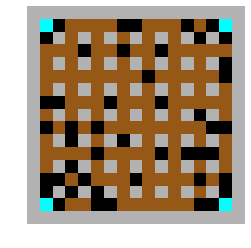

In [24]:
anim = animation(imgs[:60], interval=300)
HTML(anim.to_jshtml())

In [25]:
#for i in range(len(slices[22])):
#    slices[22][i].save(f'tex/images/X_channel-{i}-raw.png', 'PNG')

In [26]:
! rm anim/*
for i in range(len(imgs)):
    Image.fromarray(np.uint8(imgs[i]*255)).resize((17*10,17*10)).save('anim/{:0>3d}.png'.format(i))

In [27]:
! convert anim/*.png movie.gif

In [ ]:
! apt-get update
! apt-get install -y imagemagick

In [30]:
game.score

{'tensor_agent': 1,
 'simple_agent0': 1,
 'simple_agent1': 10,
 'simple_agent2': 2}